<a href="https://colab.research.google.com/github/anthonybabich/cap-comp215/blob/main/Shellings_Segregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Schelling's Segregation Model**
--------------------------

####Author: Anthony Babich 

####Date: 2023-04-19 

####Credits: chap11.ipynb notebook and chapter 11 from the runestone textbook

** **


Backround: In 1969, Thomas Schelling published “Models of Segregation”, which proposed a simple model of racial segregation. The model is based on a grid world where each cell represents a house. The houses are occupied by two kinds of agents, labeled red and blue, in roughly equal numbers. About 10% of the houses are empty. 

At any point in time, an agent might be happy or unhappy, depending on the other agents in the neighborhood, where the “neighborhood” of each house is the set of eight adjacent cells. In one version of the model, agents are happy if they have at least two neighbors like themselves, and unhappy if they have one or zero.

The simulation proceeds by choosing an agent at random and checking to see whether they are happy. If so, nothing happens; if not, the agent chooses one of the unoccupied cells at random and moves. This process continues until no more moves can be made or the system reaches a steady state.

This notebook will develop this model and run some experiments with it. First lets begin with importing the neccesary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import correlate2d
from matplotlib.colors import LinearSegmentedColormap


`locs_where` is a wrapper on `np.nonzero` that returns results as a list of tuples. This will be used in the model

In [2]:
def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: list of location tuples
    """
    return list(zip(*np.nonzero(condition)))

Here is the implementation of the model

The model represents a grid of agents.

In each time step of the simulation, the model checks whether each agent is happy with its neighbors, based on a specified threshold for the fraction of neighbors of the same type. If an agent is unhappy, it will move to a random empty cell in the grid.

The process of agents moving around the grid is repeated until no more agents are unhappy, or until a maximum number of time steps is reached. The model outputs the average fraction of neighbors of the same type for all non-empty cells in the final configuration of the grid.

This model helps us understand how segregation can arise even in the absence of explicit discrimination or prejudice, and can provide insight into policies for promoting diverse and integrated neighborhoods.













In [3]:
# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)

class Schelling:
    """Represents a grid of Schelling agents."""
    
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p, num_types=2, empty_val=0):
        """Initializes the attributes.

        n: number of rows
        p: threshold on the fraction of similar neighbors
        num_types: number of agent types (excluding empty)
        empty_val: integer value to represent empty cells
        """
        self.p = p
        self.empty_val = empty_val
        
        # Initialize the array with random agent types and empty cells
        choices = np.array([empty_val] + list(range(1, num_types+1)), dtype=np.int8)
        probs = np.ones(num_types+1) / (num_types+1)
        self.array = np.random.choice(choices, (n, n), p=probs)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, mode='same', boundary='wrap')
        num_blue = correlate2d(blue, self.kernel, mode='same', boundary='wrap')
        num_neighbors = num_red + num_blue

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
        
        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        
        return empty, frac_red, frac_blue, frac_same



    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over non-empty cells
        """
        _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same[frac_same>=0])

    def step(self):   
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
        unhappy_locs = locs_where(unhappy)
        
        # find the empty cells
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        num_empty = np.sum(empty)
        for source in unhappy_locs:
            i = np.random.randint(num_empty)
            dest = empty_locs[i]
            
            # move
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source
        
        # check that the number of empty cells is unchanged
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)


    def draw(self, ax=None):
        """Draws the grid with colors representing the different types of agents."""
        if ax is None:
          fig, ax = plt.subplots()
        ax.imshow(self.array, cmap=cmap, vmin=0, vmax=2)
        ax.set_xticks([])
        ax.set_yticks([])




      

Here is an example of the shellings model. The resulting image will show a 10x10 grid of cells, each colored according to the type of agent (or white if the cell is empty). Since the agents are randomly assigned at initialization, the resulting pattern may not exhibit significant segregation at this stage. However, if the simulation is run for multiple time steps, patterns of segregation may emerge as agents move to be closer to neighbors of their own type.

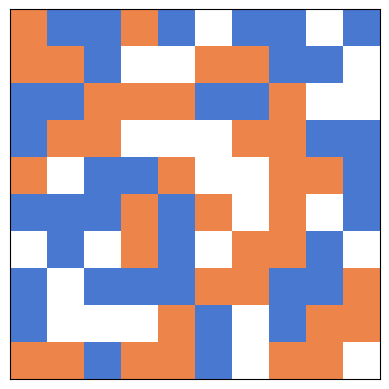

In [4]:
grid = Schelling(n=10, p=0.3)
grid.draw()


Here is an experiment that creates an instance of the Schelling model with a grid size of 100 and a threshold probability of 0.3. It then runs the Schelling model for 2 and 100 time steps and plots the resulting grid in the second and third subplots. It should show the agents moving closer to their own type indicating signs of segregation

<ipython-input-3-6ec7a4547e07>:50: RuntimeWarning: invalid value encountered in true_divide
  frac_red = num_red / num_neighbors
<ipython-input-3-6ec7a4547e07>:51: RuntimeWarning: invalid value encountered in true_divide
  frac_blue = num_blue / num_neighbors


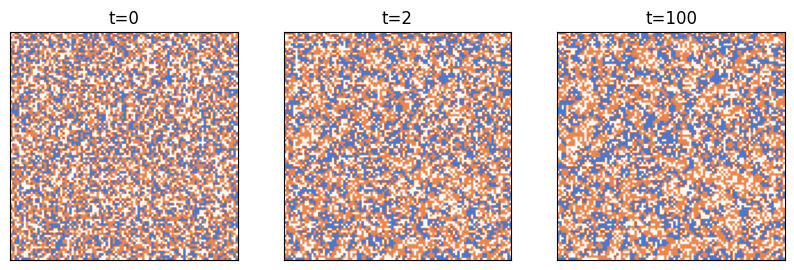

In [5]:
grid = Schelling(n=100, p=0.3)

# create a figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

# plot the initial state in the first subplot
grid.draw(ax=axs[0])
axs[0].set_title('t=0')

# run the model for 2 and 10 time steps and plot the results
for i, t in enumerate([2, 100]):
    for _ in range(t):
        grid.step()
    grid.draw(ax=axs[i+1])
    axs[i+1].set_title(f't={t}')

# display the figure
plt.show()


 Here is an experiment that shows how segregation in steady state relates to p, the threshold on the fraction of similar neighbors.  The results show that as the value of p decreases the agents become more tolerant and the level of segregation in the steady state also decreases. This can be observed from the plot, where the curves for higher values of p converge to a higher level of segregation compared to the curves for lower values of p. This can be explained by the fact that when agents are more tolerant, they are more likely to accept neighbors who are different from them, and hence, the neighborhoods become more diverse, resulting in less segregation. On the other hand, when agents have a higher threshold for similarity, they are less likely to accept neighbors who are different from them, resulting in more segregated neighborhoods.

<ipython-input-3-6ec7a4547e07>:50: RuntimeWarning: invalid value encountered in true_divide
  frac_red = num_red / num_neighbors
<ipython-input-3-6ec7a4547e07>:51: RuntimeWarning: invalid value encountered in true_divide
  frac_blue = num_blue / num_neighbors


0.5 0.8921384533194721 0.39213845331947206
0.4 0.8234844742287232 0.42348447422872315
0.3 0.7523333762591574 0.4523333762591574
0.2 0.6025298974737178 0.40252989747371776


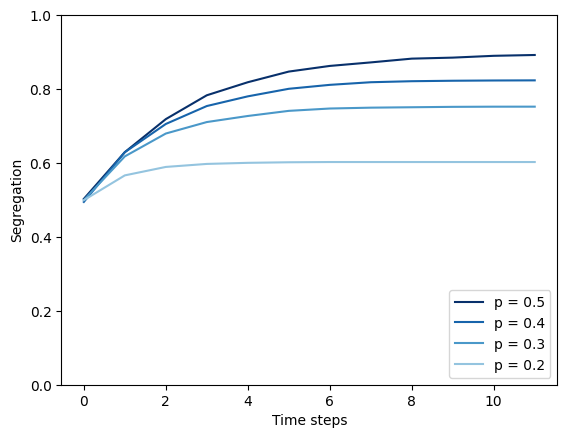

In [6]:
# set color palette
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Blues(np.linspace(0.2, 1, 5))[::-1])

np.random.seed(17)
for p in [0.5, 0.4, 0.3, 0.2]:
    grid = Schelling(n=100, p=p)
    segs = [grid.step() for i in range(12)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
plt.xlabel('Time steps')
plt.ylabel('Segregation')
plt.legend(loc='lower right')
plt.ylim([0, 1])

plt.show()
